In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.metrics import mean_absolute_error, mean_squared_error
from matplotlib.dates import WeekdayLocator
import os
import glob

In [6]:
# Set font properties using rcParams
plt.rcParams['font.family'] = 'Arial'

In [7]:
#define data path
data_dir=r'W:\VUB\sensors\tms_sensor_data\vremde\latest'

In [8]:
#from the data directory import data from all loggers. Files with data are labelled beginning with data--
data_files=glob.glob(os.path.join(data_dir,'data_94*')) #load all files starting with rf in the folder

In [10]:
data_files

['W:\\VUB\\sensors\\tms_sensor_data\\vremde\\latest\\data_94207202_2023_06_08_1.csv',
 'W:\\VUB\\sensors\\tms_sensor_data\\vremde\\latest\\data_94207215_2023_06_08_0.csv',
 'W:\\VUB\\sensors\\tms_sensor_data\\vremde\\latest\\data_94207227_2023_06_08_0.csv',
 'W:\\VUB\\sensors\\tms_sensor_data\\vremde\\latest\\data_94207232_2023_06_08_0.csv']

In [20]:
#extract the names of the loggers
loggers=[]
for data_file in data_files:
    names=os.path.basename(data_file.split('_')[3])
    loggers.append(names)

In [21]:
loggers

['94207202', '94207215', '94207227', '94207232']

In [22]:
col_names=['date','timezone','Temp: -6cm','Temp: 0cm','Temp: +12cm','raw SM']

In [23]:
#format the data for each sensor to a time indexed dataframe
micro_climate_data=[]
for st in data_files:
    logger_data=pd.read_csv(st, sep=';', header=None)
    logger_data=logger_data.iloc[:,1:7]
    logger_data.columns=col_names
    logger_data['datetime'] = pd.to_datetime(logger_data['date'], format='%Y.%m.%d %H:%M')
    logger_data_timeindex=logger_data.set_index('datetime').drop('date', axis=1)
    logger_data_timeindex.replace(',', '.', regex=True, inplace=True) #replace , with . in Temp values
    logger_data_timeindex=logger_data_timeindex.astype(float)
    logger_data_timeindex=logger_data_timeindex.drop('timezone', axis=1)
    #resample to daily
    daily_data=logger_data_timeindex.resample('.25H').mean()
    micro_climate_data.append(daily_data)

### Extract soil moisture data

In [105]:
sm_values=[]
for df in micro_climate_data:
    sm=df['raw SM']
    sm_values.append(sm)
sm_df=pd.concat(sm_values,axis=1)
sm_df.columns=loggers

sm_df_field=sm_df['2023-03-23':]
#sensors were put in the field in Mid-March

#separate sensors by depth of installation: All sensors beginning with 94.. were installed in March
sm_25=sm_df_field.iloc[:,3:]
sm_50=sm_df_field.iloc[:,0:3]['2023-03-21':]

In [106]:
def plot_sm(df, y_label,labels, weekinterval,ylims):
    fig,ax=plt.subplots(figsize=(10,3.5),dpi=150)
    plt.plot(df,label=labels)
    plt.grid(alpha=0.5)
    ax.xaxis.set_major_locator(WeekdayLocator(byweekday=0,interval=weekinterval))
    plt.ylabel(y_label)
    plt.ylim(ylims)
    plt.legend(loc='lower left')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


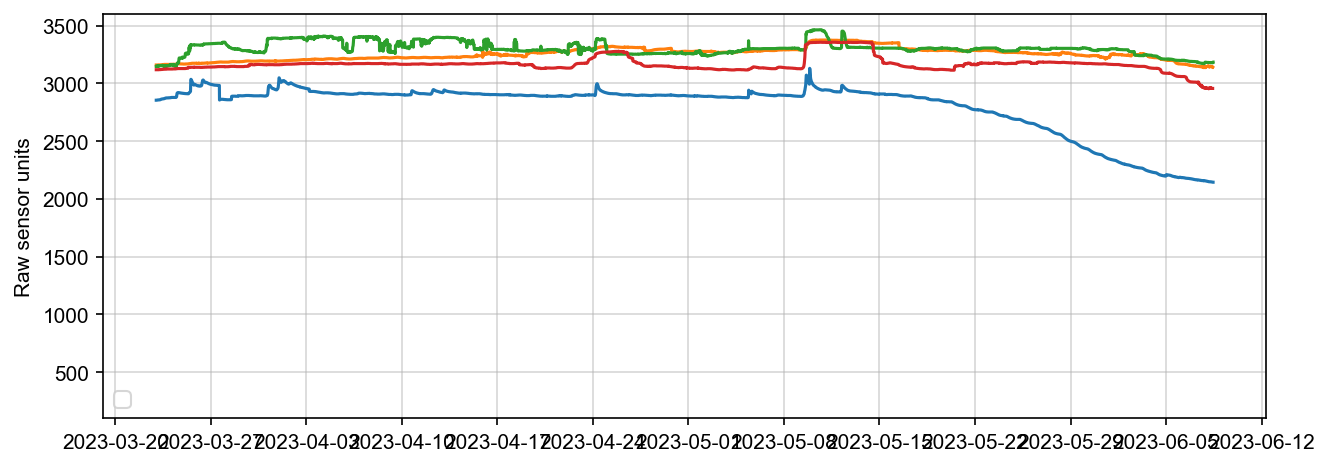

In [107]:
plot_sm(sm_df_field, 'Raw sensor units', labels='', weekinterval=1,ylims=[100,3600])

### Inter-sensor-variability

For sensors on or around the same location

In [108]:
# generic calibration equation from Kopecký, Macek & Wild (2021) 
#vwc=-0.0000000134*raw_sm**2 + 0.000249622*raw_sm - 0.157889

In [109]:
def get_vmc(raw_vals):
    vmc=-0.0000000134*raw_vals**2 + 0.000249622*raw_vals - 0.157889
    return vmc

In [110]:
sm_25_vmc=get_vmc(sm_25)
sm_25_vmc['mean']=sm_25_vmc.mean(axis=1)

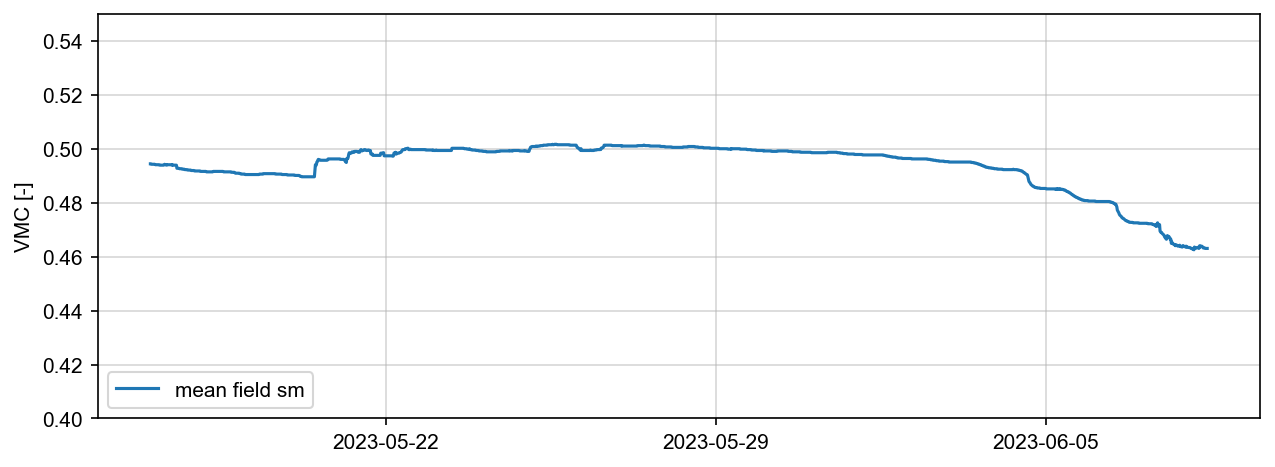

In [111]:
plot_sm(sm_25_vmc.loc[:,['mean']]['2023-05-17':],'VMC [-]',labels='mean field sm',weekinterval=1,ylims=[0.40,0.55])

In [112]:
sm_50_vmc=get_vmc(sm_50)
sm_50_vmc['mean']=sm_50_vmc.mean(axis=1)

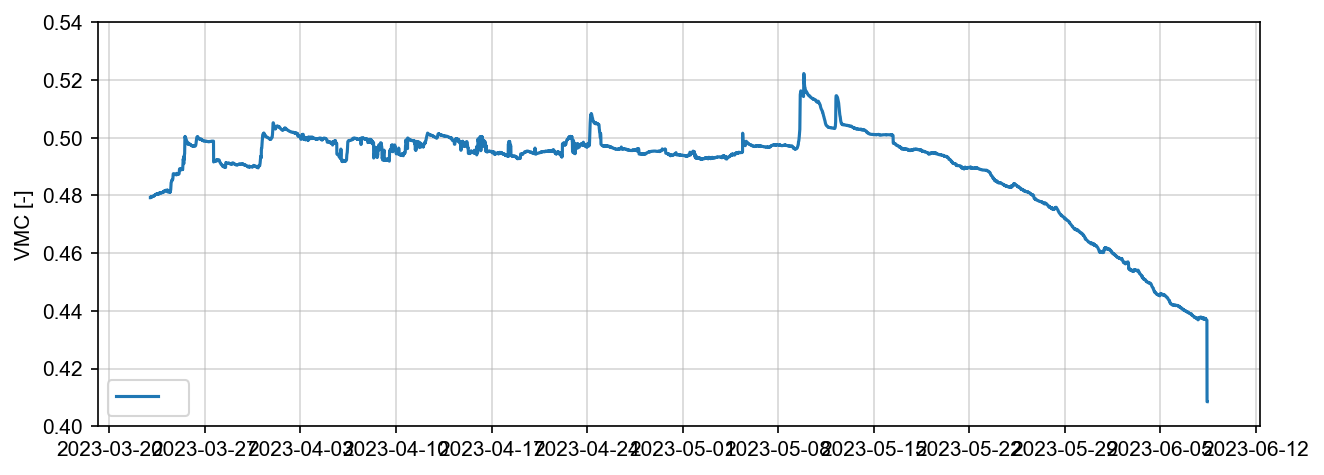

In [113]:
plot_sm(sm_50_vmc.loc[:,['mean']],'VMC [-]',labels=' ', weekinterval=1,ylims=[0.40,0.54])

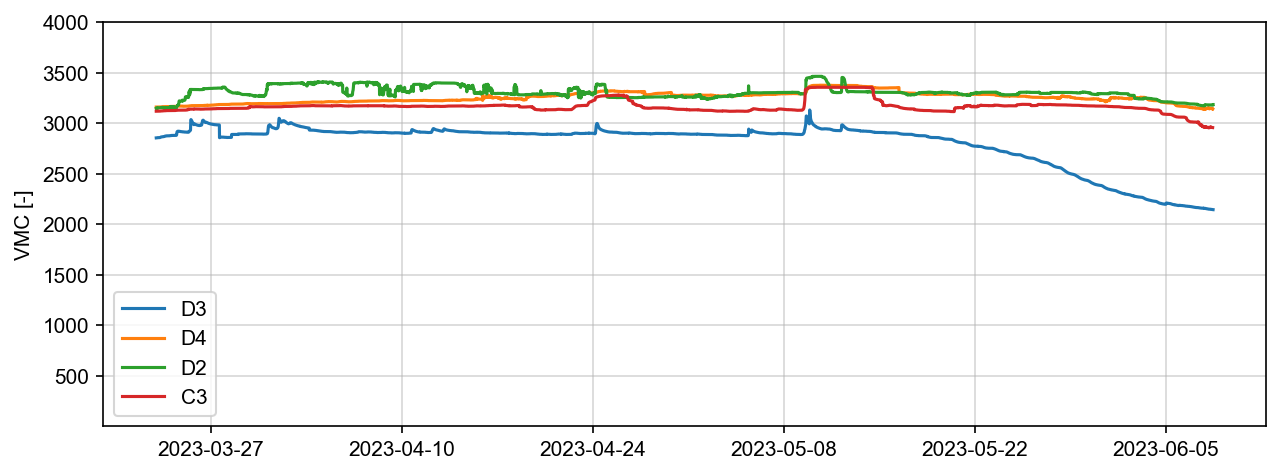

In [116]:
labels_25=['D3','D4','D2','C3']
label_50=['w','r','m']
plot_sm(sm_df_field,'VMC [-]',labels=labels_25, weekinterval=2,ylims=[0.1,4000])

In [16]:
variables=['Temp: -6cm','Temp: 0cm','Temp: +12cm','raw SM']

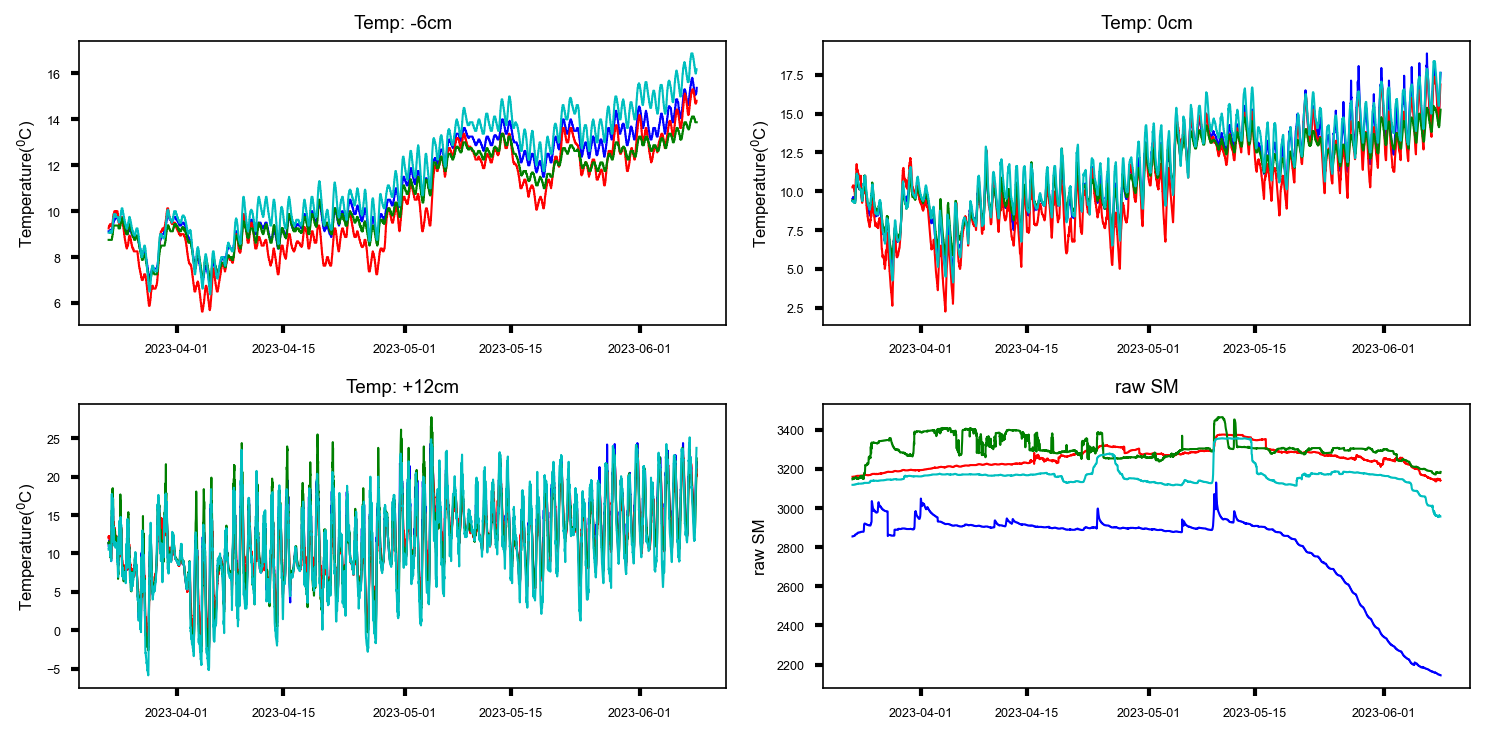

In [18]:
import matplotlib.pyplot as plt
import pandas as pd

# Create a figure with subplots for each of the four measurements
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 5), dpi=150)

# Define the measurement labels
measurements = variables

# Define the colors for the plot
colors = ['blue', 'red','green', 'c']
# Loop through each measurement and each dataframe and plot the comparison
for i, measurement in enumerate(measurements):
    row = i // 2
    col = i % 2
    for j, df in enumerate(micro_climate_data):
        axs[row, col].plot(df[measurement]['2023-03-23':], label='Logger_{}'.format(loggers[j]),linewidth=1., color=colors[j % len(colors)])
    axs[row, col].set_title('{}'.format(measurement), fontsize=9)
    
    #set ylabels according to variables
    if measurement in measurements[0:3]:
        axs[row, col].set_ylabel('Temperature($^0$C)', fontsize=8)
    else:
        axs[row, col].set_ylabel('raw SM', fontsize=8)
   # axs[row, col].set_ylabel(measurement, fontsize=8)
    axs[row, col].tick_params(axis='both', which='major', labelsize=6, length=4, width=2, pad=5, labelcolor='black', direction='out', labelrotation=0,bottom=True,  grid_alpha=0.5)
    #axs[row, col].legend(fontsize=7)
    
# Adjust the spacing between subplots and save the figure
fig.tight_layout()

# Adjust the spacing between subplots and save the figure
fig.tight_layout()
#plt.savefig('inter-sensor variability.png', dpi=300)
plt.show()